In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

## Data Loading and Cleaning

The dataset contains three subsets. As a first step, we load all datasets and create one pandas dataframe to include all the useful features and information for our project. Given our goal is to forecast 

In [2]:
asset_df = pd.read_csv('assets.txt', sep=",")
events_df = pd.read_csv('events.txt', sep=",")
sale_events_df = pd.read_csv('sale_events.txt', sep=",")

# Change the price formation of total_price to remove redundant 0's for each price
adj_price = []
for i in range(len(sale_events_df)):
    adj_price.append(float(sale_events_df.loc[i]['total_price']) / 10e+18)

sale_events_df.total_price = adj_price

C:\Users\oswal\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (0,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


For asset_df, we drop all the rows that are not an token entry. Since we will just use token_id to join different dataframes, we will drop the "id" column. Additionally, we will drop the "image_url", "permalink" and "collection" columns since they do not add information for our model. 

In [3]:
asset_df_clean = asset_df.drop(asset_df[asset_df.token_id == 'token_id'].index, axis=0)
asset_df_clean = asset_df_clean.drop(labels=['id', 'image_url', 'permalink', 'collection'], axis=1)

For sale_events_df, we will create the average sales price for each token_id and use the price as the target to train the model. Since other informations (except created_date) all have the same value, they do not provide additional information for our forecast and thus are dropped. 

In [4]:
token_id = sale_events_df.token_id.unique()
price_df = pd.DataFrame(columns=['token_id', 'ave_price'])

for i in range(len(token_id)):
    current_token = token_id[i]
    current_price = sale_events_df[sale_events_df.token_id == current_token].total_price.mean()
    price_df.loc[i] = [str(current_token), current_price]

Notice that only a subset of all the items have a transaction price. We merge the price dataframe together with the feature dataframe, keeping only those items with prices. 

In [5]:
price_df['token_id'] = price_df['token_id'].astype(str)
asset_df_clean['token_id'] = asset_df_clean['token_id'].astype(str)
df = price_df.merge(asset_df_clean, on='token_id')
df

,token_id,ave_price,face_value,face_count,body_value,body_count,shirt_value,shirt_count,tier_value,tier_count,hats_value,hats_count
0,9932,0.707250,mononoke,237,blue cat skin,9933,buttondown green,220,cool_2,2584,mohawk purple,221
1,9925,0.144000,stunned,247,blue cat skin,9933,hoodie purple,193,cool_1,1979,mohawk purple,221
2,9924,0.174000,sunglasses cool,209,blue cat skin,9933,tshirt pink,203,wild_1,1743,bow,84
3,9923,0.069000,glossy,211,blue cat skin,9933,bandana red,218,cool_1,1979,mohawk purple,221
4,9921,0.131475,angry scar,227,blue cat skin,9933,work blue,198,cool_2,2584,bucket hat green,235
...,...,...,...,...,...,...,...,...,...,...,...,...
844,8951,0.077000,angry cute,250,blue cat skin,9933,astro orange,60,classy_2,747,nurse,81
845,8934,0.266200,sunglasses cool,209,blue cat skin,9933,nurse,60,wild_1,1743,piercings,209
846,8944,0.007000,angry,243,blue cat skin,9933,punk,63,wild_2,1241,sunhat black,105
847,8914,0.203429,ninja black,221,blue cat skin,9933,tanktop white,203,wild_1,1743,helm bronze,66


## Exploratory Data Analysis (EDA)

### Average Price

First, we take a look at the distribution of average transaction price, defined as the average of all the transaction prices during the underlying period. As stated earlier, prices were normalized by dividing by 1e+18 to remove redundant errors at the end. Hereafter, price refers to the normalized price. 

In [6]:
df.ave_price.describe()

count    849.000000
mean       0.258887
std        1.845453
min        0.001000
25%        0.028633
50%        0.090000
75%        0.276000
max       53.406667
Name: ave_price, dtype: float64

We can see that most of the prices are less than 1, but there are a few outliers (such as 53.4). The histogram below shows the distribution of prices (ignoring outliers greater than 1). 

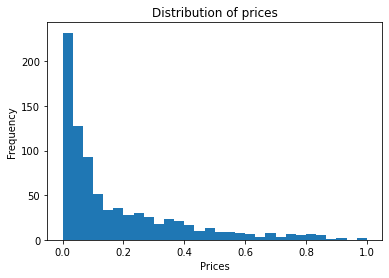

In [7]:
plt.hist(df.ave_price, bins=30, range=(0, 1))
plt.title('Distribution of prices')
plt.xlabel('Prices')
plt.ylabel('Frequency')
plt.show()

### Features

There are in total five different features: face_value, body_value, shirt_value, tier_value and hat_value, and they are all categorical variables. Since most of the features have many unique values (above 50), showing their relationship with price in a plot is difficult. We will use summary tables to show the average transaction price for each category. For the feature "tier_value", we will show the distribution of price for each category in a box plot. Lastly, since all the samples have "blue cat skin" as their body_value, we ignore the feature body_value in our EDA. 

First, for the feature "face_value", we can see the average transaction prices ranges from 0.08 (for "sunglass cowboy" category) to 0.93 (for "tvface 404" category). The average price for "tired" category is 2.5, which is likely caused by an outlier. 

In [8]:
df.groupby(by='face_value').mean().sort_values(by='ave_price')

,ave_price
face_value,
sunglasses cowboy,0.082845
tvface xp,0.085000
tvface bobross,0.094375
owo,0.101692
sunglasses heart,0.125325
glasses funny,0.137678
uwu,0.145815
sunglasses yellow,0.149023
double face,0.151860


For the feature "shirt_value", the average transaction prices ranges from 0.05 (for "monk" category) to 0.72 (for "robe king" category). The average price for "ninja black" category is 9.33, which is likely caused by an outlier.

In [9]:
df.groupby(by='shirt_value').mean().sort_values(by='ave_price')

,ave_price
shirt_value,
monk,0.052745
overalls yellow,0.052983
cowboy black,0.062329
pirate black,0.064692
knight leather,0.067500
...,...
astro orange,0.433159
astro black,0.441112
combat black,0.471111


For the feature "hats_value", the average transaction prices ranges from 0.01 (for "knight_blue" category) to 0.89 (for "knight black" category). The average price for "flower pink" category is 2.33, which is likely caused by an outlier.

In [10]:
df.groupby(by='hats_value').mean().sort_values(by='ave_price')

,ave_price
hats_value,
knight blue,0.014310
halo,0.022000
visor green,0.044736
deepsea bronze,0.049000
deepsea orange,0.064000
...,...
crown gold,0.548750
costume frog,0.550229
tvhead grey,0.557107


Lastly, below shows the boxplot of each category of the feature "tier_value". We notice that the category "exotic_2" clearly has a higher median than the other categories, and the categories "dassy_1", "dassy_2" and "exotic_2" are more dispersed in price than the other ones. 

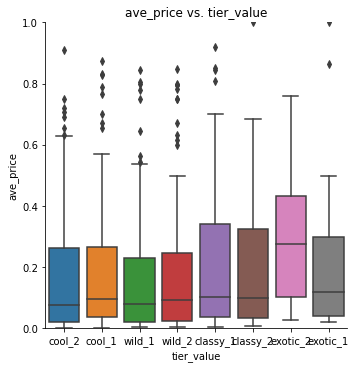

In [11]:
tier_value_plot = sns.catplot(x="tier_value", y="ave_price", kind="box",  data=df)
tier_value_plot.set(ylim=(0, 1))
plt.title('ave_price vs. tier_value')
plt.show()

### Feature Counts

Lastly, we examine if the count for each feature is related to average price, i.e., whether features having more counts are likely to be associated with higher price (possibly due to higher preference/demand for this feature) or lower price (due to less rareness). 

To begin with, we examine the relations between face_count (how many occurance of each face value in the collection) and the average price of each face value. The scatter plot below shows that most of the face values have more than 200 counts, but there is no clear pattern showing higher count would lead to either higher or lower average price. 

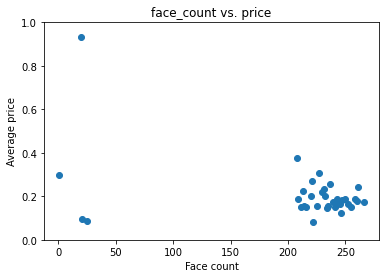

In [12]:
face_count = df.face_count.unique()
price = []
for current_face_count in face_count:
    current_price = df[df.face_count == current_face_count].ave_price.mean()
    price.append(current_price)
face_count = face_count.astype(int)

plt.scatter(x=face_count, y=price)
plt.ylim([0, 1])
plt.title('face_count vs. price')
plt.xlabel('Face count')
plt.ylabel('Average price')
plt.show()

For the relationship between shirt_count and price, it is also not clear if a higher shirt count is associated with a higher or lower average price. 

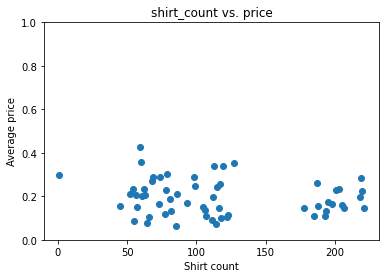

In [13]:
shirt_count = df.shirt_count.unique()
price = []
for current_shirt_count in shirt_count:
    current_price = df[df.shirt_count == current_shirt_count].ave_price.mean()
    price.append(current_price)
shirt_count = shirt_count.astype(int)

plt.scatter(x=shirt_count, y=price)
plt.ylim([0, 1])
plt.title('shirt_count vs. price')
plt.xlabel('Shirt count')
plt.ylabel('Average price')
plt.show()

For the relationship between tier_count and price, it is also not clear if a higher tier count is associated with a higher or lower average price.

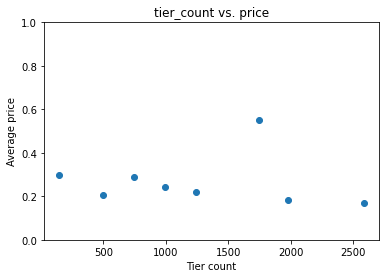

In [14]:
tier_count = df.tier_count.unique()
price = []
for current_tier_count in tier_count:
    current_price = df[df.tier_count == current_tier_count].ave_price.mean()
    price.append(current_price)
tier_count = tier_count.astype(int)

plt.scatter(x=tier_count, y=price)
plt.ylim([0, 1])
plt.title('tier_count vs. price')
plt.xlabel('Tier count')
plt.ylabel('Average price')
plt.show()

Lastly, for the relationship between hats_count and price, there is no clear pattern on whether a higher hats_count is associated with a higher or lower average price. 

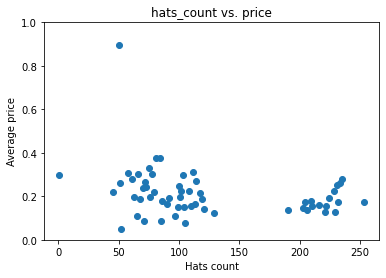

In [15]:
hats_count = df.hats_count.unique()
price = []
for current_hats_count in hats_count:
    current_price = df[df.hats_count == current_hats_count].ave_price.mean()
    price.append(current_price)
hats_count = hats_count.astype(int)

plt.scatter(x=hats_count, y=price)
plt.ylim([0, 1])
plt.title('hats_count vs. price')
plt.xlabel('Hats count')
plt.ylabel('Average price')
plt.show()

### Baseline Model

We implement a baseline linear regression based on the probability of the traits occurring in the NFT.

In [16]:
# Randomizing the rows in the dataset.
df = df.sample(frac=1)
df.head()

,token_id,ave_price,face_value,face_count,body_value,body_count,shirt_value,shirt_count,tier_value,tier_count,hats_value,hats_count
217,9661,0.190000,tired,229,blue cat skin,9933,labcoat,118,cool_2,2584,antlers,232
573,9243,0.334975,double face,241,blue cat skin,9933,robe blue,219,cool_2,2584,hat visor yellow,224
461,9368,0.099750,ditto,266,blue cat skin,9933,tshirt white,99,classy_2,747,crown fire,58
50,9853,0.002000,dizzy,235,blue cat skin,9933,gown purple,74,wild_1,1743,mohawk purple,221
720,9070,0.014000,glossy,211,blue cat skin,9933,toga,113,cool_2,2584,bucket hat green,235


In [17]:
# Computing the probabilities based on frequency counts.
num_items_in_collection = 9935
df['face_count_prob'] = df['face_count'].astype('int') / num_items_in_collection
df['body_count_prob'] = df['body_count'].astype('int') / num_items_in_collection
df['shirt_count_prob'] = df['shirt_count'].astype('int') / num_items_in_collection
df['tier_count_prob'] = df['tier_count'].astype('int') / num_items_in_collection
df['hats_count_prob'] = df['hats_count'].astype('int') / num_items_in_collection

df.head()

,token_id,ave_price,face_value,face_count,body_value,body_count,shirt_value,shirt_count,tier_value,tier_count,hats_value,hats_count,face_count_prob,body_count_prob,shirt_count_prob,tier_count_prob,hats_count_prob
217,9661,0.190000,tired,229,blue cat skin,9933,labcoat,118,cool_2,2584,antlers,232,0.023050,0.999799,0.011877,0.260091,0.023352
573,9243,0.334975,double face,241,blue cat skin,9933,robe blue,219,cool_2,2584,hat visor yellow,224,0.024258,0.999799,0.022043,0.260091,0.022547
461,9368,0.099750,ditto,266,blue cat skin,9933,tshirt white,99,classy_2,747,crown fire,58,0.026774,0.999799,0.009965,0.075189,0.005838
50,9853,0.002000,dizzy,235,blue cat skin,9933,gown purple,74,wild_1,1743,mohawk purple,221,0.023654,0.999799,0.007448,0.175440,0.022245
720,9070,0.014000,glossy,211,blue cat skin,9933,toga,113,cool_2,2584,bucket hat green,235,0.021238,0.999799,0.011374,0.260091,0.023654


In [18]:
# Splitting data into 80% training and 20% test.
train, test = df.iloc[:int(len(df)*0.8),:], df.iloc[int(len(df)*0.8):,:]

In [19]:
# Creating X and Y sets.
features = ['face_count_prob', 'body_count_prob', 'shirt_count_prob', 'tier_count_prob', 'hats_count_prob' ]
target_variable = 'ave_price'

X_train = train[features]
Y_train = train[target_variable]

X_test = test[features]
Y_test = test[target_variable]

In [20]:
# Create linear regression model
linear_regression = linear_model.LinearRegression()

In [21]:
# Fit linear regression model.
linear_regression.fit(X_train, Y_train)

LinearRegression()

In [22]:
# Make predictions on the test set.
Y_test_predictions = linear_regression.predict(X_test)

In [23]:
# Results of linear regression.
print("Coefficients: \n", linear_regression.coef_)
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Coefficients: 
 [-1.37754290e+01  7.10542736e-15 -2.69093686e+01  3.11892358e-01
  1.27429898e+01]
Mean squared error: 0.12
R2 score: -0.23


# Predicting the last sale.

We focus on predicting the last sale price of an item, so that we can use the historical sales history as a feature.

In [24]:
last_sales_df = sale_events_df.sort_values(by='created_date', ascending=True).groupby('token_id').tail(1)

In [25]:
last_sales_df.head(10)

,token_id,collection,event_type,auction_type,bid_amount,ending_price,created_date,total_price,quantity
1644,9251,cool-cats-nft,successful,None,None,None,2021-07-01T23:17:45.410098,0.00110,1
1719,9212,cool-cats-nft,successful,None,None,None,2021-07-01T23:18:16.130480,0.00100,1
113,9866,cool-cats-nft,successful,None,None,None,2021-07-02T00:27:17.110235,0.00200,1
2153,9006,cool-cats-nft,successful,None,None,None,2021-07-02T01:11:58.291430,0.00270,1
2195,9002,cool-cats-nft,successful,None,None,None,2021-07-02T01:21:34.506466,0.00270,1
1567,9263,cool-cats-nft,successful,None,None,None,2021-07-02T02:20:57.317321,0.00200,1
1220,9409,cool-cats-nft,successful,None,None,None,2021-07-02T02:40:42.816273,0.00200,1
623,9639,cool-cats-nft,successful,None,None,None,2021-07-02T02:41:30.611609,0.00197,1
2249,9000,cool-cats-nft,successful,None,None,None,2021-07-02T02:49:37.223770,0.00400,1
1936,9126,cool-cats-nft,successful,None,None,None,2021-07-02T03:11:27.159422,0.00200,1


In [26]:
last_sales_df.loc[last_sales_df['token_id'] == 9932]

,token_id,collection,event_type,auction_type,bid_amount,ending_price,created_date,total_price,quantity
0,9932,cool-cats-nft,successful,None,None,None,2021-10-21T19:16:22.725846,0.655,1


In [27]:
last_sales_df = last_sales_df[['token_id', 'total_price']]

last_sales_df.columns = ['token_id', 'last_price']

last_sales_df.head(10)

,token_id,last_price
1644,9251,0.00110
1719,9212,0.00100
113,9866,0.00200
2153,9006,0.00270
2195,9002,0.00270
1567,9263,0.00200
1220,9409,0.00200
623,9639,0.00197
2249,9000,0.00400
1936,9126,0.00200


In [28]:
df = df.astype({'token_id' : int})

df = df.merge(last_sales_df, on='token_id', how='left')

df.head(10)


,token_id,ave_price,face_value,face_count,body_value,body_count,shirt_value,shirt_count,tier_value,tier_count,hats_value,hats_count,face_count_prob,body_count_prob,shirt_count_prob,tier_count_prob,hats_count_prob,last_price
0,9661,0.190000,tired,229,blue cat skin,9933,labcoat,118,cool_2,2584,antlers,232,0.023050,0.999799,0.011877,0.260091,0.023352,0.190
1,9243,0.334975,double face,241,blue cat skin,9933,robe blue,219,cool_2,2584,hat visor yellow,224,0.024258,0.999799,0.022043,0.260091,0.022547,1.235
2,9368,0.099750,ditto,266,blue cat skin,9933,tshirt white,99,classy_2,747,crown fire,58,0.026774,0.999799,0.009965,0.075189,0.005838,0.250
3,9853,0.002000,dizzy,235,blue cat skin,9933,gown purple,74,wild_1,1743,mohawk purple,221,0.023654,0.999799,0.007448,0.175440,0.022245,0.002
4,9070,0.014000,glossy,211,blue cat skin,9933,toga,113,cool_2,2584,bucket hat green,235,0.021238,0.999799,0.011374,0.260091,0.023654,0.014
5,9265,0.017500,angry scar,227,blue cat skin,9933,overalls pink,93,wild_2,1241,apple,229,0.022849,0.999799,0.009361,0.124912,0.023050,0.029
6,8970,0.002000,sunglasses cowboy,222,blue cat skin,9933,robe blue,219,cool_1,1979,headband red,216,0.022345,0.999799,0.022043,0.199195,0.021741,0.002
7,9155,1.131667,sunglasses squad,213,blue cat skin,9933,ninja red,119,wild_2,1241,mullet blonde,100,0.021439,0.999799,0.011978,0.124912,0.010065,1.800
8,8920,0.056967,glasses,235,blue cat skin,9933,work red,205,cool_1,1979,wreath,203,0.023654,0.999799,0.020634,0.199195,0.020433,0.088
9,9631,0.079000,wink,220,blue cat skin,9933,epaulette red,64,classy_2,747,knight red,90,0.022144,0.999799,0.006442,0.075189,0.009059,0.079


In [29]:
# Adding log_last_price
df['log_last_price'] = np.log(1 + df['last_price'])

df.head(20)


,token_id,ave_price,face_value,face_count,body_value,body_count,shirt_value,shirt_count,tier_value,tier_count,hats_value,hats_count,face_count_prob,body_count_prob,shirt_count_prob,tier_count_prob,hats_count_prob,last_price,log_last_price
0,9661,0.190000,tired,229,blue cat skin,9933,labcoat,118,cool_2,2584,antlers,232,0.023050,0.999799,0.011877,0.260091,0.023352,0.19000,0.173953
1,9243,0.334975,double face,241,blue cat skin,9933,robe blue,219,cool_2,2584,hat visor yellow,224,0.024258,0.999799,0.022043,0.260091,0.022547,1.23500,0.804241
2,9368,0.099750,ditto,266,blue cat skin,9933,tshirt white,99,classy_2,747,crown fire,58,0.026774,0.999799,0.009965,0.075189,0.005838,0.25000,0.223144
3,9853,0.002000,dizzy,235,blue cat skin,9933,gown purple,74,wild_1,1743,mohawk purple,221,0.023654,0.999799,0.007448,0.175440,0.022245,0.00200,0.001998
4,9070,0.014000,glossy,211,blue cat skin,9933,toga,113,cool_2,2584,bucket hat green,235,0.021238,0.999799,0.011374,0.260091,0.023654,0.01400,0.013903
5,9265,0.017500,angry scar,227,blue cat skin,9933,overalls pink,93,wild_2,1241,apple,229,0.022849,0.999799,0.009361,0.124912,0.023050,0.02900,0.028587
6,8970,0.002000,sunglasses cowboy,222,blue cat skin,9933,robe blue,219,cool_1,1979,headband red,216,0.022345,0.999799,0.022043,0.199195,0.021741,0.00200,0.001998
7,9155,1.131667,sunglasses squad,213,blue cat skin,9933,ninja red,119,wild_2,1241,mullet blonde,100,0.021439,0.999799,0.011978,0.124912,0.010065,1.80000,1.029619
8,8920,0.056967,glasses,235,blue cat skin,9933,work red,205,cool_1,1979,wreath,203,0.023654,0.999799,0.020634,0.199195,0.020433,0.08800,0.084341
9,9631,0.079000,wink,220,blue cat skin,9933,epaulette red,64,classy_2,747,knight red,90,0.022144,0.999799,0.006442,0.075189,0.009059,0.07900,0.076035


We compute the 'number of sales' feature.

In [30]:
# Extracting num_sales
sales_count_df = sale_events_df.sort_values(by='created_date', ascending=True).groupby('token_id').count()

sales_count_df = sales_count_df.reset_index()

sales_count_df = sales_count_df[['token_id', 'quantity']]

sales_count_df.columns = ['token_id', 'num_sales']

df = df.merge(sales_count_df, on='token_id', how='left')

df.head(10)

,token_id,ave_price,face_value,face_count,body_value,body_count,shirt_value,shirt_count,tier_value,tier_count,hats_value,hats_count,face_count_prob,body_count_prob,shirt_count_prob,tier_count_prob,hats_count_prob,last_price,log_last_price,num_sales
0,9661,0.190000,tired,229,blue cat skin,9933,labcoat,118,cool_2,2584,antlers,232,0.023050,0.999799,0.011877,0.260091,0.023352,0.190,0.173953,1
1,9243,0.334975,double face,241,blue cat skin,9933,robe blue,219,cool_2,2584,hat visor yellow,224,0.024258,0.999799,0.022043,0.260091,0.022547,1.235,0.804241,4
2,9368,0.099750,ditto,266,blue cat skin,9933,tshirt white,99,classy_2,747,crown fire,58,0.026774,0.999799,0.009965,0.075189,0.005838,0.250,0.223144,4
3,9853,0.002000,dizzy,235,blue cat skin,9933,gown purple,74,wild_1,1743,mohawk purple,221,0.023654,0.999799,0.007448,0.175440,0.022245,0.002,0.001998,1
4,9070,0.014000,glossy,211,blue cat skin,9933,toga,113,cool_2,2584,bucket hat green,235,0.021238,0.999799,0.011374,0.260091,0.023654,0.014,0.013903,1
5,9265,0.017500,angry scar,227,blue cat skin,9933,overalls pink,93,wild_2,1241,apple,229,0.022849,0.999799,0.009361,0.124912,0.023050,0.029,0.028587,2
6,8970,0.002000,sunglasses cowboy,222,blue cat skin,9933,robe blue,219,cool_1,1979,headband red,216,0.022345,0.999799,0.022043,0.199195,0.021741,0.002,0.001998,1
7,9155,1.131667,sunglasses squad,213,blue cat skin,9933,ninja red,119,wild_2,1241,mullet blonde,100,0.021439,0.999799,0.011978,0.124912,0.010065,1.800,1.029619,3
8,8920,0.056967,glasses,235,blue cat skin,9933,work red,205,cool_1,1979,wreath,203,0.023654,0.999799,0.020634,0.199195,0.020433,0.088,0.084341,3
9,9631,0.079000,wink,220,blue cat skin,9933,epaulette red,64,classy_2,747,knight red,90,0.022144,0.999799,0.006442,0.075189,0.009059,0.079,0.076035,1


We compute the historical average price that excludes the last sale price (target variable) to be used as a feature.

In [31]:
# Adding historical_average_price
# Removing the weighted average of the last sale (which we're trying to predict.)
df['historical_ave_price'] = df['ave_price'] - df['last_price'] / df['num_sales']

df.head(20)

,token_id,ave_price,face_value,face_count,body_value,body_count,shirt_value,shirt_count,tier_value,tier_count,...,hats_count,face_count_prob,body_count_prob,shirt_count_prob,tier_count_prob,hats_count_prob,last_price,log_last_price,num_sales,historical_ave_price
0,9661,0.190000,tired,229,blue cat skin,9933,labcoat,118,cool_2,2584,...,232,0.023050,0.999799,0.011877,0.260091,0.023352,0.19000,0.173953,1,0.000000
1,9243,0.334975,double face,241,blue cat skin,9933,robe blue,219,cool_2,2584,...,224,0.024258,0.999799,0.022043,0.260091,0.022547,1.23500,0.804241,4,0.026225
2,9368,0.099750,ditto,266,blue cat skin,9933,tshirt white,99,classy_2,747,...,58,0.026774,0.999799,0.009965,0.075189,0.005838,0.25000,0.223144,4,0.037250
3,9853,0.002000,dizzy,235,blue cat skin,9933,gown purple,74,wild_1,1743,...,221,0.023654,0.999799,0.007448,0.175440,0.022245,0.00200,0.001998,1,0.000000
4,9070,0.014000,glossy,211,blue cat skin,9933,toga,113,cool_2,2584,...,235,0.021238,0.999799,0.011374,0.260091,0.023654,0.01400,0.013903,1,0.000000
5,9265,0.017500,angry scar,227,blue cat skin,9933,overalls pink,93,wild_2,1241,...,229,0.022849,0.999799,0.009361,0.124912,0.023050,0.02900,0.028587,2,0.003000
6,8970,0.002000,sunglasses cowboy,222,blue cat skin,9933,robe blue,219,cool_1,1979,...,216,0.022345,0.999799,0.022043,0.199195,0.021741,0.00200,0.001998,1,0.000000
7,9155,1.131667,sunglasses squad,213,blue cat skin,9933,ninja red,119,wild_2,1241,...,100,0.021439,0.999799,0.011978,0.124912,0.010065,1.80000,1.029619,3,0.531667
8,8920,0.056967,glasses,235,blue cat skin,9933,work red,205,cool_1,1979,...,203,0.023654,0.999799,0.020634,0.199195,0.020433,0.08800,0.084341,3,0.027633
9,9631,0.079000,wink,220,blue cat skin,9933,epaulette red,64,classy_2,747,...,90,0.022144,0.999799,0.006442,0.075189,0.009059,0.07900,0.076035,1,0.000000


We compute one-hot-encoding variables for each of the NFT attributes, to account for the possibility that attributes with the same rarity might have different impact in sale prices.

In [80]:
# Setting categorical columns.
categorical_columns = ['face_value', 'body_value', 'shirt_value', 'tier_value', 'hats_value']
for categorical_column in categorical_columns:
    df = pd.concat([df,pd.get_dummies(df[categorical_column], prefix=categorical_column)],axis=1)
        


We keep NFTs that have at least one historical sale price, otherwise we're limited to simply the NFT attributes, which is a limited indicator of sale prices.

In [81]:
# NOTE: Restricting to examples with non-empty historical sales.
pos_df = df[df.num_sales > 1]

We split into training 90% and 10% test set.

In [82]:
# Splitting data into 80% training and 20% test.
train, test = pos_df.iloc[:int(len(df)*0.8),:], df.iloc[int(len(df)*0.8):,:]

We perform model comparison including the attribute probabilities, one-hot encoded categorical variables and average historical price and number of sales.

In [83]:
# Creating X and Y sets.
features = [x for x in df.columns if x != 'last_price' and x != 'ave_price' and x != 'face_value' and x != 'body_value'
           and x != 'shirt_value' and x != 'hats_value' and x != 'tier_value' and x != 'log_last_price']

target_variable = 'last_price'

X_train = train[features]
Y_train = train[target_variable]

for feature in features:
    print(feature)

X_test = test[features]
Y_test = test[target_variable]

print(df.columns)

token_id
face_count
body_count
shirt_count
tier_count
hats_count
face_count_prob
body_count_prob
shirt_count_prob
tier_count_prob
hats_count_prob
num_sales
historical_ave_price
face_value_alien
face_value_angry
face_value_angry cute
face_value_angry scar
face_value_beard brown
face_value_beard pirate
face_value_beard tan
face_value_derp
face_value_ditto
face_value_dizzy
face_value_double face
face_value_face face
face_value_glasses
face_value_glasses funny
face_value_glossy
face_value_grin
face_value_happy
face_value_happy cute
face_value_hearts
face_value_mononoke
face_value_mummy
face_value_ninja black
face_value_ninja blue
face_value_ninja red
face_value_owo
face_value_pixel
face_value_rich
face_value_shocked
face_value_smirk
face_value_stunned
face_value_sunglasses blue
face_value_sunglasses cool
face_value_sunglasses cowboy
face_value_sunglasses heart
face_value_sunglasses pixel
face_value_sunglasses squad
face_value_sunglasses yellow
face_value_three eyes
face_value_tired
face_va

In [84]:
# Create linear regression model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
linear_regression = make_pipeline(StandardScaler(),
                     linear_model.LinearRegression())

In [85]:
# Fit linear regression model.
linear_regression.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [86]:
# Make predictions on the test set.
Y_test_predictions = linear_regression.predict(X_test)

In [87]:
# Results of linear regression.
#print("Coefficients: \n", linear_regression.coef_)
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.17
R2 score: 0.44


In [88]:
Y_test_predictions[:10]

array([ 0.27361822, -0.07940912,  0.15057135,  0.3810401 ,  0.01775885,
        0.4122901 ,  0.27752447,  0.51189947,  0.35174322,  0.51287603])

In [89]:
Y_test[:10]

679    0.01500
680    0.00225
681    0.20000
682    0.97450
683    0.08880
684    0.06900
685    0.16500
686    0.40000
687    0.00800
688    0.00290
Name: last_price, dtype: float64

In [90]:
# Applying KNN
from sklearn.neighbors import KNeighborsRegressor
knnRegressor = make_pipeline(StandardScaler(),
                     KNeighborsRegressor(n_neighbors=100))

knnRegressor.fit(X_train, Y_train)
Y_test_predictions = knnRegressor.predict(X_test)

In [91]:
# Results of KNN.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.29
R2 score: 0.01


In [92]:
Y_test_predictions[:10]

array([0.38281385, 0.38086909, 0.3989018 , 0.3838491 , 0.397369  ,
       0.41248515, 0.4119776 , 0.4145179 , 0.4062496 , 0.41729224])

In [93]:
# Kernel Ridge
from sklearn.kernel_ridge import KernelRidge
krr = make_pipeline(StandardScaler(),
                    KernelRidge())
krr.fit(X_train, Y_train)
Y_test_predictions = krr.predict(X_test)

In [94]:
# Results of KNN.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.32
R2 score: -0.08


In [95]:
Y_test_predictions[:10]

array([-0.19959876, -0.45569796, -0.35012617, -0.14988128, -0.2963982 ,
       -0.09950798, -0.09355561,  0.05308066, -0.26517585, -0.04987197])

In [96]:
# Ridge CV
from sklearn.linear_model import RidgeCV

ridgeCV = make_pipeline(StandardScaler(),
                    RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, Y_train))
ridgeCV.fit(X_train, Y_train)
Y_test_predictions = ridgeCV.predict(X_test)

In [97]:
# Results of KNN.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.17
R2 score: 0.43


In [98]:
Y_test_predictions[:10]

array([ 0.2454869 , -0.01061231,  0.09495948,  0.29520437,  0.14868746,
        0.34557768,  0.35153004,  0.49816631,  0.17990981,  0.39521369])

In [99]:
# SGD Regressor.
from sklearn.linear_model import SGDRegressor
#sgdRegressor = SGDRegressor(max_iter=1000, tol=1e-3)
reg = make_pipeline(StandardScaler(),
                     SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train, Y_train)
Y_test_predictions = reg.predict(X_test)

In [100]:
# Results of KNN.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.16
R2 score: 0.44


In [101]:
Y_test_predictions[:10]

array([ 0.26040293, -0.08433196,  0.05048822,  0.33203839,  0.1125268 ,
        0.38688061,  0.38985578,  0.43089525,  0.14669794,  0.45210679])

In [102]:
# Bayesian ARD
from sklearn import linear_model

ard = make_pipeline(StandardScaler(),
                    linear_model.ARDRegression())
ard.fit(X_train, Y_train)
Y_test_predictions = ard.predict(X_test)

In [103]:
# Results of ARD.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.15
R2 score: 0.49


In [104]:
# Bayesian Ridge

bayesRidge = make_pipeline(StandardScaler(),
                    linear_model.BayesianRidge())
bayesRidge.fit(X_train, Y_train)
Y_test_predictions = bayesRidge.predict(X_test)

In [105]:
# Results of Bayesian Ridge.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.21
R2 score: 0.29


In [106]:
# MLP Regressor
from sklearn.neural_network import MLPRegressor

mlpRegressor = make_pipeline(StandardScaler(),
                    MLPRegressor(random_state=1, max_iter=500))
mlpRegressor.fit(X_train, Y_train)
Y_test_predictions = mlpRegressor.predict(X_test)

In [107]:
# Results of MLP Regressor.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.20
R2 score: 0.32


In [108]:
# Linear SVR
from sklearn.svm import LinearSVR

linearSVR = make_pipeline(StandardScaler(),
                    LinearSVR(random_state=0, tol=1e-5, max_iter = 3000))
linearSVR.fit(X_train, Y_train)
Y_test_predictions = linearSVR.predict(X_test)

C:\Users\oswal\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [109]:
# Results of Linear SVR.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.21
R2 score: 0.30


In [110]:
# Nu SVR
from sklearn.svm import NuSVR

nuSVR = make_pipeline(StandardScaler(),
                    NuSVR(C=1.0, nu=0.1))
nuSVR.fit(X_train, Y_train)
Y_test_predictions = nuSVR.predict(X_test)

In [111]:
# Results of Nu SVR.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.20
R2 score: 0.32


In [112]:
# SVR
from sklearn.svm import SVR

svr = make_pipeline(StandardScaler(),
                    SVR(C=1.0, epsilon=0.2))
svr.fit(X_train, Y_train)
Y_test_predictions = svr.predict(X_test)

In [113]:
# Results of SVR.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.13
R2 score: 0.57


In [114]:
# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

decisionTreeRegressor = make_pipeline(StandardScaler(),
                    DecisionTreeRegressor(random_state=0))
decisionTreeRegressor.fit(X_train, Y_train)
Y_test_predictions = decisionTreeRegressor.predict(X_test)

In [115]:
# Results of Decision Tree Regressor.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.07
R2 score: 0.76


In [116]:
# Extra Tree Regressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor

extra_tree = ExtraTreeRegressor(random_state=0)
baggingRegressor = BaggingRegressor(extra_tree, random_state=0).fit(X_train, Y_train)

Y_test_predictions = baggingRegressor.predict(X_test)

In [117]:
# Results of Extra Tree Regressor.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.09
R2 score: 0.71


After our initial exploration, we train and test the model with the following feature sets in order to compare the predictive values of different features:

1) Feature Set 1: Probability counts of attributes.

2) Feature Set 2: Probability counts of attributes and one-hot encoded attributes.

3) Feature Set 3: Probability counts of attributes, one-hot encoded attributes, and summary features of historical sales(number of sales and average historical sale prices).

In [138]:
# Runs a model and adds the results to 'results' variable.
def score_model(model_name, model, feature_set, X_train, Y_train, X_test, Y_test, results):
    model.fit(X_train, Y_train)
    Y_test_predictions = model.predict(X_test)
    results.append([model_name, feature_set, mean_squared_error(Y_test, Y_test_predictions), r2_score(Y_test, Y_test_predictions)])

# Score all available models on a given train/test set.
def score_all_models(X_train, Y_train, X_test, Y_test, feature_set, results):
    models = { 'linear_regression' : make_pipeline(StandardScaler(), linear_model.LinearRegression()),
               'knnRegressor' : make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=100)),
               'ridgeCV' : make_pipeline(StandardScaler(), RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])),
               'SGDRegressor' : make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3)),
               'ARDRegression' : make_pipeline(StandardScaler(), linear_model.ARDRegression()),
               'BayesianRidge' : make_pipeline(StandardScaler(), linear_model.BayesianRidge()),
               'MLPRegressor' : make_pipeline(StandardScaler(), MLPRegressor(random_state=1, max_iter=500)),
               'NuSVR' : make_pipeline(StandardScaler(), NuSVR(C=1.0, nu=0.1)),
               'SVR' : make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2)),
               'DecisionTreeRegressor' : make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=0)),
               'BaggingRegressor' : BaggingRegressor(ExtraTreeRegressor(random_state=0), random_state=0)
             }
    
    for model_name, model in models.items():
        score_model(model_name, model, feature_set, X_train, Y_train, X_test, Y_test, results)
        
def score_all_models_all_feature_sets(X_train, Y_train, X_test, Y_test, results):
    # Probabilities of attributes.
    feature_set_1 = ['face_count_prob', 'body_count_prob', 'shirt_count_prob', 'tier_count_prob', 'hats_count_prob']
    
    score_all_models(X_train[feature_set_1], Y_train, X_test[feature_set_1], Y_test, feature_set = 1, results = results)
    
    # Probabilities of attributes and categorical variables for attributes. 
    feature_set_2 = [x for x in df.columns if x != 'last_price' and x != 'ave_price' and x != 'face_value' and x != 'body_value'
           and x != 'shirt_value' and x != 'hats_value' and x != 'tier_value' and x != 'log_last_price' and 
           x != 'num_sales' and x != 'historical_ave_price' and x != 'time_series_prediction' and x != 'has_time_series_prediction']
    
    score_all_models(X_train[feature_set_2], Y_train, X_test[feature_set_2], Y_test, feature_set = 2, results = results)
    
    # Probabilities of attributes, categorical variables for attributes, and summary of sale events.
    feature_set_3 = [x for x in df.columns if x != 'last_price' and x != 'ave_price' and x != 'face_value' and x != 'body_value'
           and x != 'shirt_value' and x != 'hats_value' and x != 'tier_value' and x != 'log_last_price'
           and x != 'time_series_prediction' and x != 'has_time_series_prediction']
    
    score_all_models(X_train[feature_set_3], Y_train, X_test[feature_set_3], Y_test, feature_set = 3, results = results)
        
model_score_results = []

score_all_models_all_feature_sets(X_train, Y_train, X_test, Y_test, model_score_results)

model_score_results

[['linear_regression', 1, 0.26815333325794954, 0.09106898787152284],
 ['knnRegressor', 1, 0.28486979974435683, 0.03440694821644985],
 ['ridgeCV', 1, 0.2681908147812012, 0.09094194071364725],
 ['SGDRegressor', 1, 0.26538851149832704, 0.10044061197104903],
 ['ARDRegression', 1, 0.2708657023406734, 0.08187515706706039],
 ['BayesianRidge', 1, 0.2729264137741913, 0.07489018132122349],
 ['MLPRegressor', 1, 0.24962901848749336, 0.15385889978024636],
 ['NuSVR', 1, 0.3088883594191402, -0.04700622494768392],
 ['SVR', 1, 0.24605126997086366, 0.16598601578828498],
 ['DecisionTreeRegressor', 1, 0.09456893055720589, 0.6794496912533882],
 ['BaggingRegressor', 1, 0.10699258504384863, 0.6373385427187692],
 ['linear_regression', 2, 0.1998843054409484, 0.3224732959844613],
 ['knnRegressor', 2, 0.29271657862615136, 0.007809551181235386],
 ['ridgeCV', 2, 0.19343674817452827, 0.34432789939633146],
 ['SGDRegressor', 2, 0.19192637510759375, 0.3494474513472289],
 ['ARDRegression', 2, 0.17685928395581507, 0.400

In [161]:
# Create DF for comparing models under different feature sets.
feature_sets_results_df = pd.DataFrame(data=np.array(model_score_results), \
                                       columns=['model_name', 'feature_set', 'mse', 'r2-score'])
feature_sets_results_df = feature_sets_results_df.reset_index(drop=True)
feature_sets_results_df = feature_sets_results_df.astype({'feature_set' : int})
feature_sets_results_df = feature_sets_results_df.astype({'r2-score' : float})
feature_sets_results_df = feature_sets_results_df.astype({'mse' : float})


feature_sets_results_df.head(10)

,model_name,feature_set,mse,r2-score
0,linear_regression,1,0.268153,0.091069
1,knnRegressor,1,0.284870,0.034407
2,ridgeCV,1,0.268191,0.090942
3,SGDRegressor,1,0.265389,0.100441
4,ARDRegression,1,0.270866,0.081875
5,BayesianRidge,1,0.272926,0.074890
6,MLPRegressor,1,0.249629,0.153859
7,NuSVR,1,0.308888,-0.047006
8,SVR,1,0.246051,0.165986
9,DecisionTreeRegressor,1,0.094569,0.679450


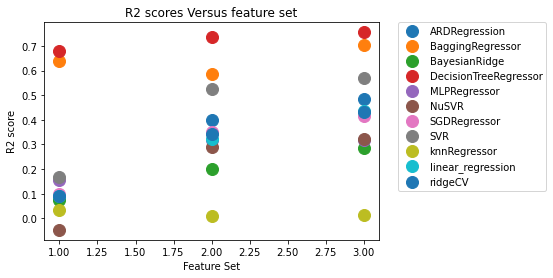

In [171]:
# Visualize R2 scores for each feature set.
groups = feature_sets_results_df.groupby('model_name')
for name, group in groups:
    plt.plot(group['feature_set'], group['r2-score'], marker='o', linestyle='', markersize=12, label=name)

plt.title('R2 scores Versus feature set')
plt.xlabel('Feature Set')
plt.ylabel('R2 score')

plt.legend(bbox_to_anchor= (1.5, 1), loc='upper right', borderaxespad=0)


We can see a general uptick in R2 performance when using increasingly larger feature sets.
For example, the DecisionTreeRegressor has an R2 performance of roughly 0.69 on the first feature set, 0.73 on the
second feature set, and 0.75 on the third feature set. The pattern holds roughly for almost all models.
Therefore, the larger feature sets show better performance than smaller feature sets.

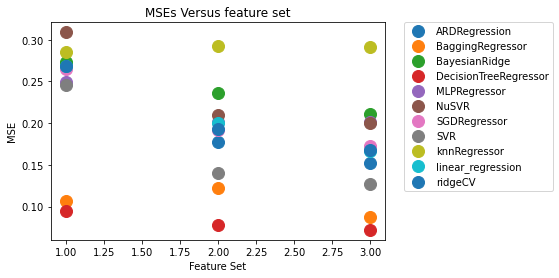

In [172]:
# Visualize MSEs for each feature set.
groups = feature_sets_results_df.groupby('model_name')
for name, group in groups:
    plt.plot(group['feature_set'], group['mse'], marker='o', linestyle='', markersize=12, label=name)



plt.title('MSEs Versus feature set')
plt.xlabel('Feature Set')
plt.ylabel('MSE')

plt.legend(bbox_to_anchor= (1.5, 1), loc='upper right', borderaxespad=0)


We see a similar pattern with MSEs (lower is better).

# Using Time Series Analysis

So far we have used aggregate features about historical sale prices such as number of sales or average, but we haven't considered the sequential nature of these events. In general, one would expect that recent prices are more relevant to the current sale price than older sale prices.

For this reason, we explore the use of a time series model.

Consider the following sales history of an NFT:

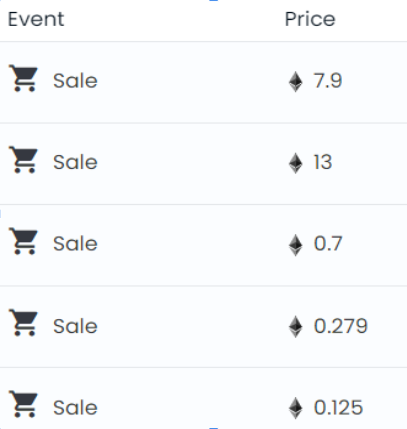

We can use sequences of sale prices to predict the next sale price in the sequence.
For example, choosing a time step t=2, we can train the model on the following examples:

- 7.9 , 13 -> 0.7
- 13, 0.7 -> 0.279

In other words, we will train the model so that by receiving 7.9 and 13, it will predict 0.7, and similarly with the second sequence.

Note that we exclude the final sequence of 0.7, 0.279 -> 0.125 from training, as we don't want to train over the sequence that we're interested in predicting. Instead, the final sequence is kept in the test set.

We exclude NFTs with less than two sales since they either have no target variable or no usable historical sales history. IN cases when we have a history smaller than the number of steps, we pad the sale events history with the lowest sale price as needed.

The architecture of our network is based from a public Kaggle notebook used for predicting closing prices for Apple: https://www.kaggle.com/faressayah/stock-market-analysis-prediction-using-lstm/notebook

We modified the original architecture into the following:

- LSTM with 8 nodes.

- Dense layer with 25 nodes.

- Dense layer with 1 node, with a linear activation. 

In [120]:
import tensorflow as tf
# This model was inspired by the following notebook for predicting Apple stock prices using time series analysis:
# https://www.kaggle.com/faressayah/stock-market-analysis-prediction-using-lstm/notebook

def add_time_series_data_for_token(sale_events_df, token_id, step_size, x_train_time_series, y_train_time_series, \
                                  x_test_time_series, y_test_time_series, token_ids):
    
    total_prices = sale_events_df.loc[sale_events_df['token_id'] == token_id]['total_price']
    
    total_prices = list(total_prices)

    # Base case: skip the time series of length < 2.
    if len(total_prices) < 2:
        return
    
    token_ids.append(str(token_id))
    
    # Pad with the first price while necessary.
    while len(total_prices) <= step_size + 1:
        total_prices.append(total_prices[-1])
        
    # Reverse so that the last price is last.
    total_prices = total_prices[::-1]

    scaled_prices = total_prices[:]
    
    # Create training data
    time_series_train_data = scaled_prices[:-1]

    for i in range(step_size, len(scaled_prices) - 1):
        x_train_time_series.append(time_series_train_data[i - step_size : i])   
        y_train_time_series.append(time_series_train_data[i])
    
    x_test_time_series.append(scaled_prices[-(step_size+1):-1])
    
    y_test_time_series.append(scaled_prices[-1])


def get_time_series_data_for_tokens(sale_events_df, step_size, token_ids):
    
    x_train_time_series = []
    y_train_time_series = []
    x_test_time_series = []
    y_test_time_series = []
    
    for token_id in df['token_id']:
        add_time_series_data_for_token(sale_events_df, token_id, step_size, x_train_time_series, y_train_time_series,
                                      x_test_time_series, y_test_time_series, token_ids)
    
    return x_train_time_series, y_train_time_series, x_test_time_series, y_test_time_series

def train_time_series_data(sale_events_df, step_size):
    token_ids = []
    
    x_train_time_series, y_train_time_series, x_test_time_series, y_test_time_series = \
        get_time_series_data_for_tokens(sale_events_df, step_size, token_ids)
    
    # Convert the x_train and y_train to numpy arrays 
    x_train_time_series, y_train_time_series = np.array(x_train_time_series), np.array(y_train_time_series)
    
    # Reshape the time series data.
    x_train_time_series = x_train_time_series.reshape(-1, step_size)
    
    
    x_train_time_series = np.reshape(x_train_time_series, (x_train_time_series.shape[0], x_train_time_series.shape[1], 1))
    
    # Fit the Neural Network.
    # Using LSTM to model time series.
    from keras.models import Sequential
    from keras.layers import Dense, LSTM

    # Build the LSTM model
    print("Training Model...")
    model = Sequential()
    
    model.add(LSTM(8, return_sequences=False, input_shape= (x_train_time_series.shape[1], 1)))
    
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(x_train_time_series, y_train_time_series, batch_size=1, epochs=10)
    
    # Compute predictions.
    
    # Convert the x_test and y_test to numpy arrays 
    x_test_time_series, y_test_time_series = np.array(x_test_time_series), np.array(y_test_time_series)
    
    # Reshape the data
    x_test_time_series = np.reshape(x_test_time_series, (x_test_time_series.shape[0], x_test_time_series.shape[1], 1 ))
    
    # Get the models predicted price values
    predictions = model.predict(x_test_time_series)
    predictions = [x[0] for x in predictions]

    # Results of Time Series.
    print("Mean squared error: %.2f" % mean_squared_error(y_test_time_series, predictions))
    print("R2 score: %.2f" % r2_score(y_test_time_series, predictions))

    return token_ids, predictions, mean_squared_error(y_test_time_series, predictions), r2_score(y_test_time_series, predictions)

# Train time series for multiple step sizes, each a given number of times.
def train_time_series_data_with_step_sizes(sale_events_df, step_sizes, num_samples):
    results = []
    for step_size in step_sizes:
        for num_sample in range(num_samples):
            print("Training time series with step " + str(step_size) + " and sample " + str(num_sample))
            token_ids, time_series_predictions, time_series_mse, time_series_r2 = train_time_series_data(sale_events_df, step_size=2)
            results.append([step_size, time_series_mse, time_series_r2])
    
    return results

# Best results is step_size = 2
token_ids, time_series_predictions, time_series_mse, time_series_r2 = train_time_series_data(sale_events_df, step_size=2)

Training Model...
Epoch 1/10
924/924 [==============================] - 2s 997us/step - loss: 27.6933
Epoch 2/10
924/924 [==============================] - 1s 970us/step - loss: 27.6948
Epoch 3/10
924/924 [==============================] - 1s 978us/step - loss: 27.6752
Epoch 4/10
924/924 [==============================] - 1s 976us/step - loss: 27.6815
Epoch 5/10
924/924 [==============================] - 1s 968us/step - loss: 27.6848
Epoch 6/10
924/924 [==============================] - 1s 966us/step - loss: 27.6868
Epoch 7/10
924/924 [==============================] - 1s 964us/step - loss: 27.6811
Epoch 8/10
924/924 [==============================] - 1s 1ms/step - loss: 27.6892
Epoch 9/10
924/924 [==============================] - 1s 1ms/step - loss: 27.6845
Epoch 10/10
924/924 [==============================] - 1s 1ms/step - loss: 27.6804
Mean squared error: 0.15
R2 score: 0.27


Below we experiment with different step sizes, but we settled on time steps of size 2.

In [ ]:
# Train with different step sizes
time_series_results = train_time_series_data_with_step_sizes(sale_events_df, step_sizes = range(1, 11), num_samples = 5)

print("Time series results:")
print("step_size, mse, r2-score")
print(time_series_results)

In [121]:
# Create DF for time series MSEs and R2 for different step sizes.
time_series_step_sizes_results_df = pd.DataFrame(data=np.array(time_series_results), \
                                                 columns=['step_size', 'mse', 'r2-score'])
time_series_step_sizes_results_df = time_series_step_sizes_results_df.reset_index(drop=True)
time_series_step_sizes_results_df = time_series_step_sizes_results_df.astype({'step_size' : int})

# Compute mean across samples.
time_series_step_sizes_results_mean_df = time_series_step_sizes_results_df.groupby(by='step_size').mean()
time_series_step_sizes_results_mean_df = time_series_step_sizes_results_mean_df.reset_index()

time_series_step_sizes_results_mean_df.head(10)


NameError: name 'time_series_results' is not defined

In [ ]:
# Visualize r2-scores per step sizes.

plt.plot(time_series_step_sizes_results_mean_df['step_size'], time_series_step_sizes_results_mean_df['r2-score'])

plt.title('R2 scores Versus step sizes')
plt.xlabel('Step size')
plt.ylabel('R2 score')


We use the time series model to compute predictions of the last sale price, and we add these predictions as a feature to the dataset.

In [122]:
# Create dataframe for time series predictions.
time_series_array = []


for i in range(len(token_ids)):
    time_series_array.append([token_ids[i], time_series_predictions[i]])
    
time_series_df = pd.DataFrame(data=np.array(time_series_array), columns=['token_id', 'time_series_prediction'])
time_series_df = time_series_df.reset_index(drop=True)

time_series_df.head(10)

,token_id,time_series_prediction
0,9243,0.36094067
1,9368,0.38215128
2,9265,0.31547362
3,9155,1.230905
4,8920,0.35564432
5,9341,0.32384893
6,9095,0.31576815
7,9053,0.31199095
8,9132,0.31342414
9,9371,0.39228013


In [123]:
# Merge with main DF.
time_series_df = time_series_df.astype({'token_id' : int})

if 'time_series_prediction' in df.columns:
    df.drop('time_series_prediction', axis=1, inplace=True)

df = df.merge(time_series_df, on='token_id', how='left')
df = df.astype({'time_series_prediction' : float})
    
# Add flag for time series.
df['has_time_series_prediction'] = ~np.isnan(df['time_series_prediction'])
    
# Plug in average price as time series prediction for NaN.
df.time_series_prediction.fillna(df.historical_ave_price, inplace=True)
    
df.head(10)

,token_id,ave_price,face_value,face_count,body_value,body_count,shirt_value,shirt_count,tier_value,tier_count,...,hats_value_tvhead grey,hats_value_tvhead purple,hats_value_tvhead white,hats_value_unicorn horn,hats_value_visor green,hats_value_visor purple,hats_value_wreath,hats_value_wreath flowers,time_series_prediction,has_time_series_prediction
0,9661,0.190000,tired,229,blue cat skin,9933,labcoat,118,cool_2,2584,...,0,0,0,0,0,0,0,0,0.000000,False
1,9243,0.334975,double face,241,blue cat skin,9933,robe blue,219,cool_2,2584,...,0,0,0,0,0,0,0,0,0.360941,True
2,9368,0.099750,ditto,266,blue cat skin,9933,tshirt white,99,classy_2,747,...,0,0,0,0,0,0,0,0,0.382151,True
3,9853,0.002000,dizzy,235,blue cat skin,9933,gown purple,74,wild_1,1743,...,0,0,0,0,0,0,0,0,0.000000,False
4,9070,0.014000,glossy,211,blue cat skin,9933,toga,113,cool_2,2584,...,0,0,0,0,0,0,0,0,0.000000,False
5,9265,0.017500,angry scar,227,blue cat skin,9933,overalls pink,93,wild_2,1241,...,0,0,0,0,0,0,0,0,0.315474,True
6,8970,0.002000,sunglasses cowboy,222,blue cat skin,9933,robe blue,219,cool_1,1979,...,0,0,0,0,0,0,0,0,0.000000,False
7,9155,1.131667,sunglasses squad,213,blue cat skin,9933,ninja red,119,wild_2,1241,...,0,0,0,0,0,0,0,0,1.230905,True
8,8920,0.056967,glasses,235,blue cat skin,9933,work red,205,cool_1,1979,...,0,0,0,0,0,0,1,0,0.355644,True
9,9631,0.079000,wink,220,blue cat skin,9933,epaulette red,64,classy_2,747,...,0,0,0,0,0,0,0,0,0.000000,False


We perform some preliminary experiments to determine whether the time series prediction is a useful feature in our best performing models. 

In [124]:
# Training and Testing.
pos_df = df[df.num_sales > 1]
print(df.columns)

# Splitting data into 80% training and 20% test.
train, test = pos_df.iloc[:int(len(df)*0.8),:], df.iloc[int(len(df)*0.8):,:]

# Creating X and Y sets.
features = [x for x in df.columns if x != 'last_price' and x != 'ave_price' and x != 'face_value' and x != 'body_value'
           and x != 'shirt_value' and x != 'hats_value' and x != 'tier_value' and x != 'log_last_price']

target_variable = 'last_price'

X_train = train[features]
Y_train = train[target_variable]

for feature in features:
    print(feature)

X_test = test[features]
Y_test = test[target_variable]

Index(['token_id', 'ave_price', 'face_value', 'face_count', 'body_value',
       'body_count', 'shirt_value', 'shirt_count', 'tier_value', 'tier_count',
       ...
       'hats_value_tvhead grey', 'hats_value_tvhead purple',
       'hats_value_tvhead white', 'hats_value_unicorn horn',
       'hats_value_visor green', 'hats_value_visor purple',
       'hats_value_wreath', 'hats_value_wreath flowers',
       'time_series_prediction', 'has_time_series_prediction'],
      dtype='object', length=250)
token_id
face_count
body_count
shirt_count
tier_count
hats_count
face_count_prob
body_count_prob
shirt_count_prob
tier_count_prob
hats_count_prob
num_sales
historical_ave_price
face_value_alien
face_value_angry
face_value_angry cute
face_value_angry scar
face_value_beard brown
face_value_beard pirate
face_value_beard tan
face_value_derp
face_value_ditto
face_value_dizzy
face_value_double face
face_value_face face
face_value_glasses
face_value_glasses funny
face_value_glossy
face_value_grin
face

In [125]:
# Extra Tree Regressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor

extra_tree = ExtraTreeRegressor(random_state=0)
baggingRegressor = BaggingRegressor(extra_tree, random_state=0).fit(X_train, Y_train)

Y_test_predictions = baggingRegressor.predict(X_test)

In [126]:
# Results of Extra Tree Regressor
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.09
R2 score: 0.71


In [127]:
# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

decisionTreeRegressor = make_pipeline(StandardScaler(),
                    DecisionTreeRegressor(random_state=0))
decisionTreeRegressor.fit(X_train, Y_train)
Y_test_predictions = decisionTreeRegressor.predict(X_test)

In [128]:
# Results of Decision Tree Regressor.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.06
R2 score: 0.81


Below we perform a full comparison of the models with the largest feature set, with either the time series prediction or without it.

In [177]:
# Compare models with time series versus no time series.
def score_all_models_time_series_comparison(X_train, Y_train, X_test, Y_test, results):

    # Probabilities of attributes, categorical variables for attributes, and summary of sale events.
    feature_set_1 = [x for x in df.columns if x != 'last_price' and x != 'ave_price' and x != 'face_value' and x != 'body_value'
           and x != 'shirt_value' and x != 'hats_value' and x != 'tier_value' and x != 'log_last_price'
           and x != 'time_series_prediction' and x != 'has_time_series_prediction']
    
    score_all_models(X_train[feature_set_1], Y_train, X_test[feature_set_1], Y_test, feature_set = 0, results = results)
    
    # Probabilities of attributes, categorical variables for attributes, and summary of sale events.
    feature_set_2 = [x for x in df.columns if x != 'last_price' and x != 'ave_price' and x != 'face_value' and x != 'body_value'
           and x != 'shirt_value' and x != 'hats_value' and x != 'tier_value' and x != 'log_last_price']
        
    score_all_models(X_train[feature_set_2], Y_train, X_test[feature_set_2], Y_test, feature_set = 1, results = results)
        
model_score_results = []

score_all_models_time_series_comparison(X_train, Y_train, X_test, Y_test, model_score_results)

model_score_results

[['linear_regression', 0, 0.16630551862861964, 0.43629176063884956],
 ['knnRegressor', 0, 0.2909553644056946, 0.013779352878367068],
 ['ridgeCV', 0, 0.16789265404244344, 0.43091201547385427],
 ['SGDRegressor', 0, 0.16277685129426944, 0.44825251135079525],
 ['ARDRegression', 0, 0.1519349838946025, 0.48500204337866115],
 ['BayesianRidge', 0, 0.21072489972614622, 0.28572807929815347],
 ['MLPRegressor', 0, 0.2010211860294366, 0.31861973201265037],
 ['NuSVR', 0, 0.19977150921049316, 0.3228556294451955],
 ['SVR', 0, 0.12683465644277114, 0.5700819704426403],
 ['DecisionTreeRegressor', 0, 0.07210021686235295, 0.7556095153054064],
 ['BaggingRegressor', 0, 0.08698266742875653, 0.7051640455738747],
 ['linear_regression', 1, 0.11960334328751407, 0.5945931883543085],
 ['knnRegressor', 1, 0.28181621069820056, 0.04475737626679721],
 ['ridgeCV', 1, 0.11996865459321084, 0.593354931231808],
 ['SGDRegressor', 1, 0.11746981317683115, 0.6018249898737928],
 ['ARDRegression', 1, 0.12548667288415558, 0.574651

In [178]:
# Create DF for comparing models under different feature sets.
time_series_results_df = pd.DataFrame(data=np.array(model_score_results), \
                                       columns=['model_name', 'time_series', 'mse', 'r2-score'])
time_series_results_df = time_series_results_df.reset_index(drop=True)
time_series_results_df = time_series_results_df.astype({'time_series' : int})
time_series_results_df = time_series_results_df.astype({'r2-score' : float})
time_series_results_df = time_series_results_df.astype({'mse' : float})


time_series_results_df.head(10)

,model_name,time_series,mse,r2-score
0,linear_regression,0,0.166306,0.436292
1,knnRegressor,0,0.290955,0.013779
2,ridgeCV,0,0.167893,0.430912
3,SGDRegressor,0,0.162777,0.448253
4,ARDRegression,0,0.151935,0.485002
5,BayesianRidge,0,0.210725,0.285728
6,MLPRegressor,0,0.201021,0.318620
7,NuSVR,0,0.199772,0.322856
8,SVR,0,0.126835,0.570082
9,DecisionTreeRegressor,0,0.072100,0.755610


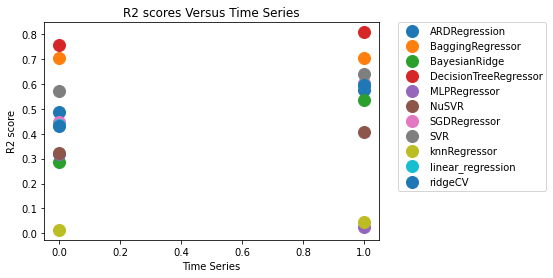

In [180]:
# Visualize R2 scores for each model without time series and with time series.
groups = time_series_results_df.groupby('model_name')
for name, group in groups:
    plt.plot(group['time_series'], group['r2-score'], marker='o', linestyle='', markersize=12, label=name)



plt.title('R2 scores Versus Time Series')
plt.xlabel('Time Series')
plt.ylabel('R2 score')

plt.legend(bbox_to_anchor= (1.5, 1), loc='upper right', borderaxespad=0)


We can see that adding the time series prediction improves the performance of almost all our models' R2 scores. In particular, 
adding the time series to the Decision Tree Regressor resulted in an R2 score improvement from 0.75 to 0.80, which is the best performance of any of the tested models.

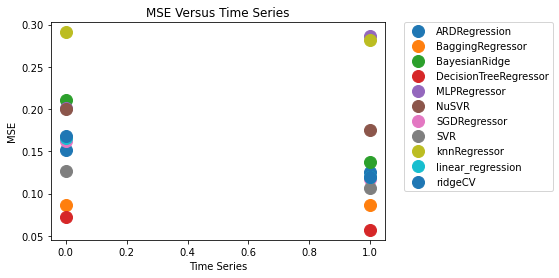

In [181]:
# Visualize MSEs for each model without time series and with time series.
groups = time_series_results_df.groupby('model_name')
for name, group in groups:
    plt.plot(group['time_series'], group['mse'], marker='o', linestyle='', markersize=12, label=name)



plt.title('MSE Versus Time Series')
plt.xlabel('Time Series')
plt.ylabel('MSE')

plt.legend(bbox_to_anchor= (1.5, 1), loc='upper right', borderaxespad=0)

Similarly, we see an almost universal drop in the MSEs when including time series predictions, which confirms the usefulness of including a time-series model as part of a model ensemble.